In [1]:
import sys
sys.path.append('/home/hrai/codes/hpe_library')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

from lib.utils.learning import * # load_backbone
from lib.utils.args import get_opts_args
from lib.utils.utils_data import flip_data
from lib.model.load_dataset import load_dataset
from lib.model.load_model import load_model
from lib.model.loss import *
from lib.model.training import *
from lib.model.evaluation import *
from lib.model.CanonDSTformer import CanonDSTformer1


os.environ["NCCL_P2P_DISABLE"]= '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'

In [2]:
config_root = 'configs/canonical2d/'
checkpoint_root = 'checkpoint/canonical2d/'
config = 'CanonDSTformer1_train_h36m_gt_tr_s1_ts_s5678_trial6.yaml'
checkpoint = 'CanonDSTformer1_train_h36m_gt_tr_s1_ts_s5678_trial6'

input_args = ['--config', config_root+config, '--evaluate', checkpoint_root+checkpoint+'/best_epoch.bin']
args, opts = get_opts_args(input_args)
print(args)

model_pos, chk_filename, checkpoint = load_model(opts, args)

configs/canonical2d/CanonDSTformer1_train_h36m_gt_tr_s1_ts_s5678_trial6.yaml
True
{'train_2d': False, 'no_eval': False, 'finetune': False, 'partial_train': None, 'canonical': False, 'test_run': False, 'epochs': 60, 'checkpoint_frequency': 30, 'batch_size': 16, 'dropout': 0.0, 'learning_rate': 0.0002, 'weight_decay': 0.01, 'lr_decay': 0.99, 'part_list': ['whole'], 'denormalize_output': False, 'backbone': 'CanonDSTformer1', 'dim_in': 2, 'dim_out': 2, 'model': 'CanonDSTformer1_train_h36m_gt_tr_s1_ts_s5678_trial6', 'maxlen': 243, 'dim_feat': 64, 'mlp_ratio': 2, 'depth': 5, 'dim_rep': 64, 'num_heads': 8, 'att_fuse': True, 'data_root': 'data/motion3d/MB3D_f243s81/', 'subset_list': ['H36M_CANONICALIZATION-GT-INPUT_FROM_3D_CANONICAL_SAME_Z-TR_S1_TS_S5678'], 'dt_file': 'h36m_gt_canonical_3d_same_z_tr_s1_ts_s5678.pkl', 'clip_len': 243, 'data_stride': 81, 'rootrel': False, 'sample_stride': 1, 'num_joints': 17, 'no_conf': True, 'gt_2d': False, 'input_mode': 'joint_2d', 'gt_mode': 'joint_2d_from_ca

In [3]:
args.dt_file, args.model, args.gt_mode, args.subset_list, args.dt_file

('h36m_gt_canonical_3d_same_z_tr_s1_ts_s5678.pkl',
 'CanonDSTformer1_train_h36m_gt_tr_s1_ts_s5678_trial6',
 'joint_2d_from_canonical_3d',
 ['H36M_CANONICALIZATION-GT-INPUT_FROM_3D_CANONICAL_SAME_Z-TR_S1_TS_S5678'],
 'h36m_gt_canonical_3d_same_z_tr_s1_ts_s5678.pkl')

In [4]:
train_loader_3d, test_loader, posetrack_loader_2d, instav_loader_2d, datareader = load_dataset(args)

Loading dataset...
H36M_CANONICALIZATION-GT-INPUT_FROM_3D_CANONICAL_SAME_Z-TR_S1_TS_S5678
H36M


In [5]:
e1, e2, results_all, inputs_all, gts_all, total_result_dict = evaluate(args, model_pos, test_loader, datareader, checkpoint, only_one_batch=False)

INFO: Testing
No epoch information in the checkpoint


100%|██████████| 323/323 [00:18<00:00, 17.92it/s]


No eval_keypoint. Use part list
Part: whole
+------------+----------------------+----------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+-----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+----------------------+----------------------+-----------------------+---------------------+-----------------------+-----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------

In [7]:
results_all.shape

(5156, 243, 17, 2)

In [15]:
error = results_all - gts_all[..., :2]
error.shape

(5156, 243, 17, 2)

In [22]:
mean_error = np.mean(np.mean(np.linalg.norm(results_all - gts_all[..., :2], axis=len(gts_all[..., :2].shape)-1), axis=1), axis=0)

In [24]:
h36m_keypoints ={
    0 : 'Pelvis',
    1 : 'R_Hip',
    2 : 'R_Knee',
    3 : 'R_Ankle',
    4 : 'L_Hip',
    5 : 'L_Knee',
    6 : 'L_Ankle',
    7 : 'Torso',
    8 : 'Neck',
    9 : 'Nose',
    10 : 'Head',
    11 : 'L_Shoulder',
    12 : 'L_Elbow',
    13 : 'L_Wrist',
    14 : 'R_Shoulder',
    15 : 'R_Elbow',
    16 : 'R_Wrist',
}

for key in h36m_keypoints.keys():
    print(h36m_keypoints[key], mean_error[key])

Pelvis 0.002687928
R_Hip 0.003464996
R_Knee 0.0050648754
R_Ankle 0.006652494
L_Hip 0.0033048636
L_Knee 0.005157218
L_Ankle 0.006710246
Torso 0.004013568
Neck 0.005436126
Nose 0.0059837666
Head 0.0069355434
L_Shoulder 0.0054123155
L_Elbow 0.0069836807
L_Wrist 0.008438234
R_Shoulder 0.0052371747
R_Elbow 0.0068068663
R_Wrist 0.008471942


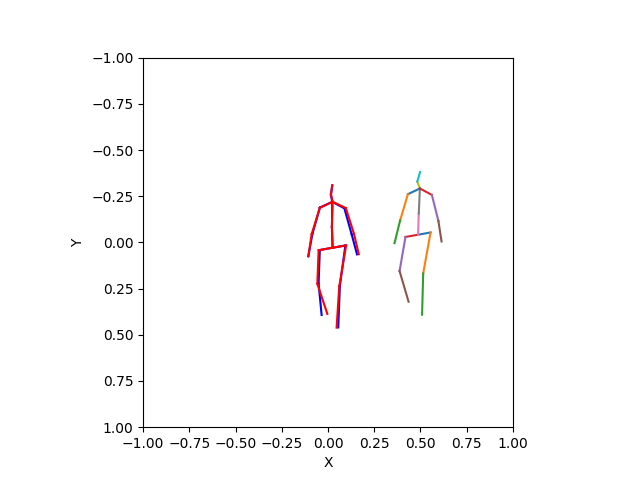

In [6]:
batch_num = 5000
frame_num = 204
input_2d = inputs_all[batch_num, frame_num]
pred = results_all[batch_num, frame_num]
gt = gts_all[batch_num, frame_num] 

%matplotlib widget
fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig, normalize=True)
draw_2d_pose(ax, input_2d, normalize=True)
draw_2d_pose(ax, gt, normalize=True, color='b')
draw_2d_pose(ax, pred, normalize=True, color='r')
#draw_2d_pose(ax, readpkl(test_files[50])['data_input'][145], normalize=True, color='b')
plt.show()

In [22]:
load_folder = '/home/hrai/codes/MotionBERT/data/motion3d/MB3D_f243s81/H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_SAME_DIST-TR_S1_TS_S5678/test'
test_folder = '/home/hrai/codes/MotionBERT/data/motion3d/MB3D_f243s81/H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_SAME_DIST-TR_S1_TS_S5678_BY_CANON1_TRIAL6_PRED/test'
if not os.path.exists(test_folder):
    os.makedirs(test_folder)
test_files = natsorted(glob(load_folder+'/*.pkl'))

In [24]:
for item in tqdm(test_files):
    data = readpkl(item)
    batch_num = int(item.split('/')[-1].split('.')[0])
    #print(data.keys(), data['data_input'].shape, data['data_label'].shape)
    data['data_input'][...,:2] = results_all[batch_num]
    #savepkl(data, item)
    break

100%|██████████| 5156/5156 [00:05<00:00, 907.23it/s]
